# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [3]:
df_azure = pd.read_csv("azure.csv")
print(df_azure.columns)
df_azure.shape

Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')


(8640, 4)

In [4]:
df_azure['timestamp'] = pd.to_datetime(df_azure['timestamp'], errors='coerce')


In [5]:
df_azure['hour'] = df_azure['timestamp'].apply(lambda x: x.hour)

# EDA

In [6]:
def draw_line_plot(df, timestamp_column, feature_column, plot_size=(10, 6)):
    # Set the size of the plot
    plt.figure(figsize=plot_size)
    
    # Plot the data with timestamp on the x-axis and the feature on the y-axis
    plt.plot(df[timestamp_column], df[feature_column], linestyle='-')
    
    # Add title and labels
    plt.title(f'Line Plot of {feature_column} over Time')
    plt.xlabel('Time')
    plt.ylabel(feature_column)
    
    # Optionally, rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Ensure a tight layout so everything fits without overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()


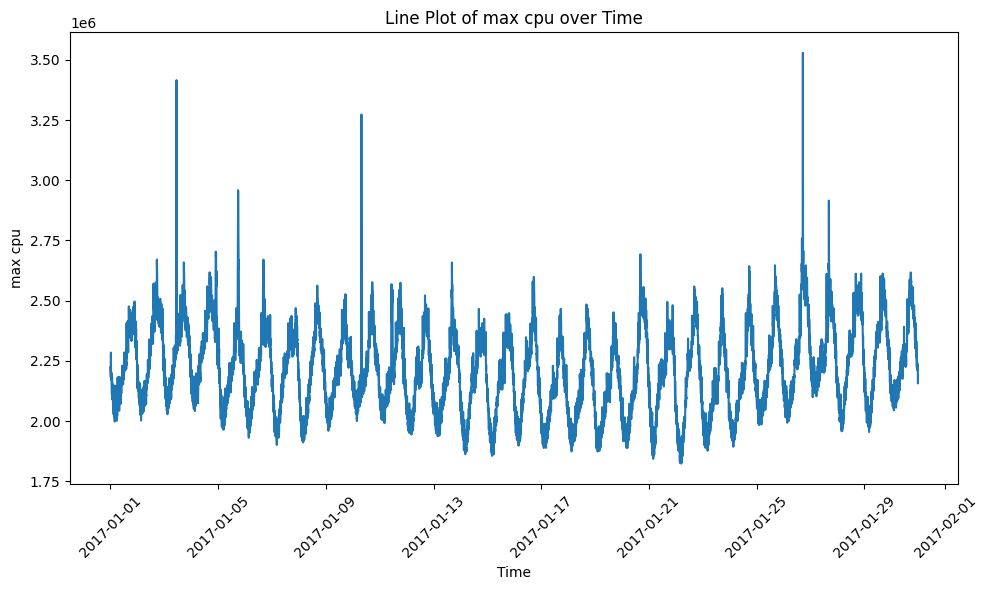

In [7]:
draw_line_plot(df_azure,"timestamp","max cpu")

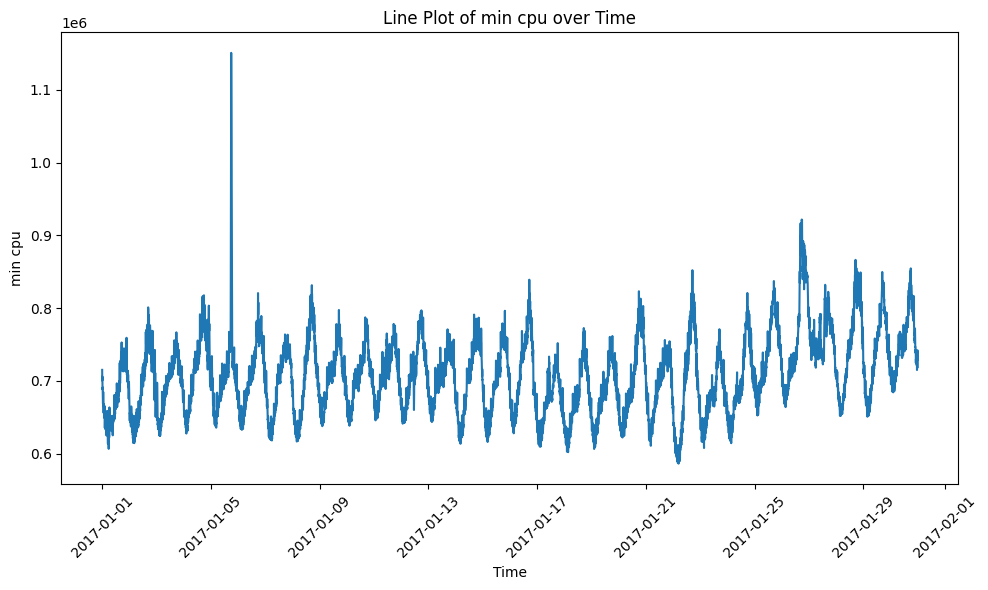

In [8]:
draw_line_plot(df_azure,"timestamp","min cpu")

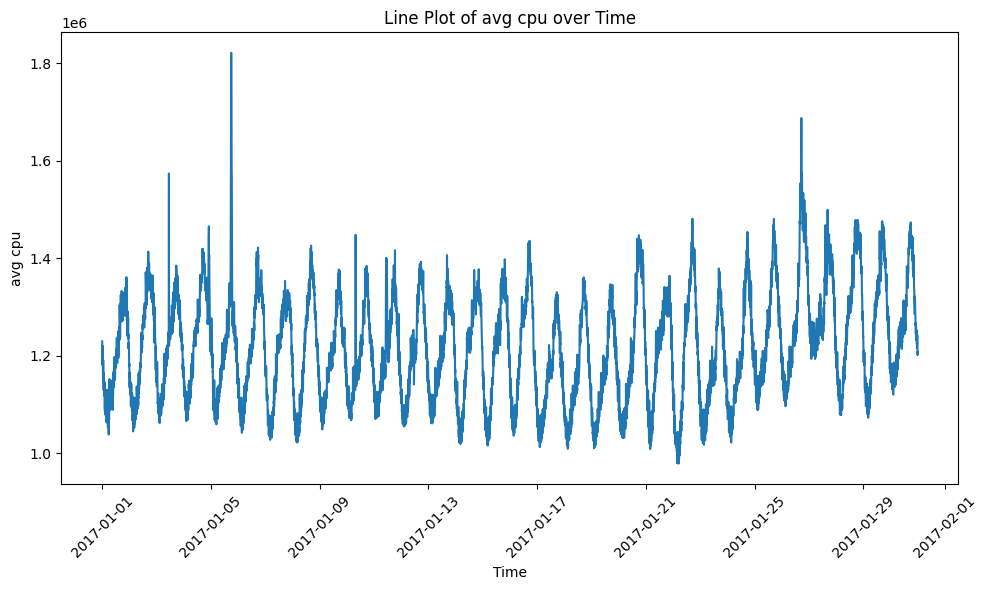

In [9]:
draw_line_plot(df_azure,"timestamp","avg cpu")

In [10]:
df_azure.isnull().sum()

timestamp    0
min cpu      0
max cpu      0
avg cpu      0
hour         0
dtype: int64

In [11]:
def hour_group(df,agg):
    state_app = df.groupby('hour').agg({'avg cpu': agg}).reset_index()  # group by
    state_app.sort_values(by=['avg cpu'],inplace=True, ascending=False) # sorting in descending order

    plt.figure(figsize=(15, 5))
    x_state = list(state_app['hour'].values) # defining x axis
    y_state = list(state_app['avg cpu'].values) # defining y axis
    plt.bar(x_state,y_state,width = 0.4)
    plt.title(f'Aggregate {agg} of avg cpu over hour')
    plt.show()

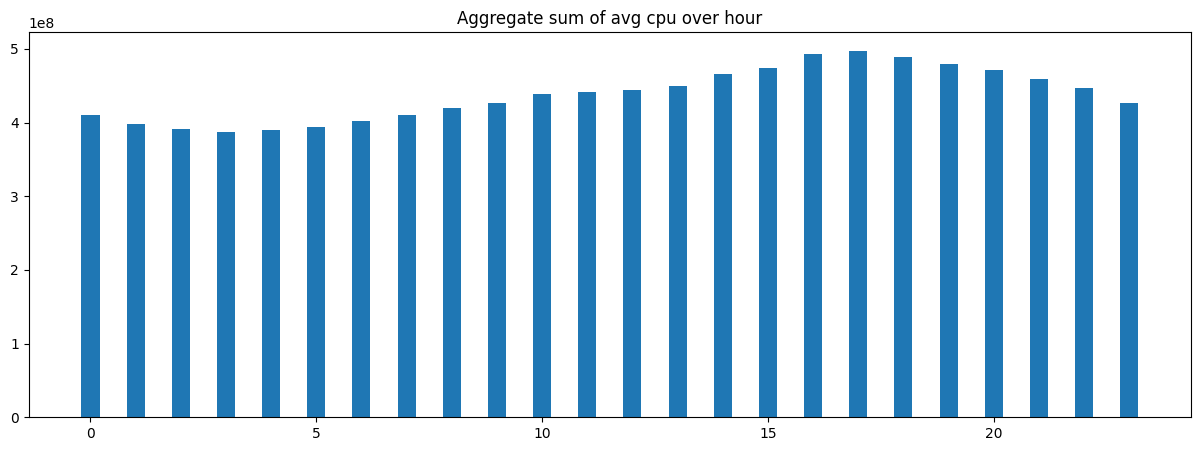

In [12]:
hour_group(df_azure,'sum')

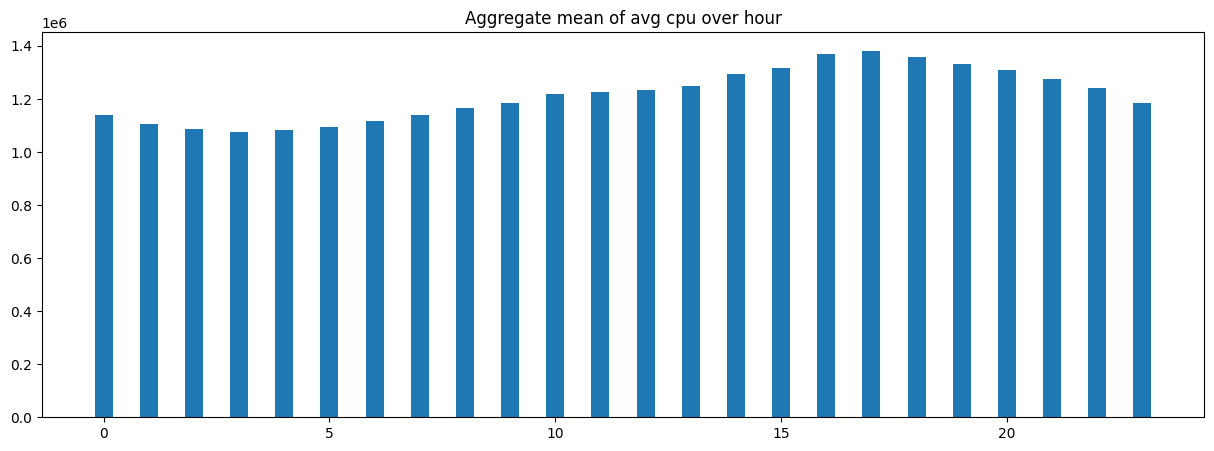

In [13]:
hour_group(df_azure,'mean')

# Arima Model

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
df = df_azure.copy()
df = df[["timestamp","avg cpu"]]
df.set_index('timestamp', inplace=True)

<Axes: title={'center': 'Average CPU Usage Over Time'}, xlabel='timestamp'>

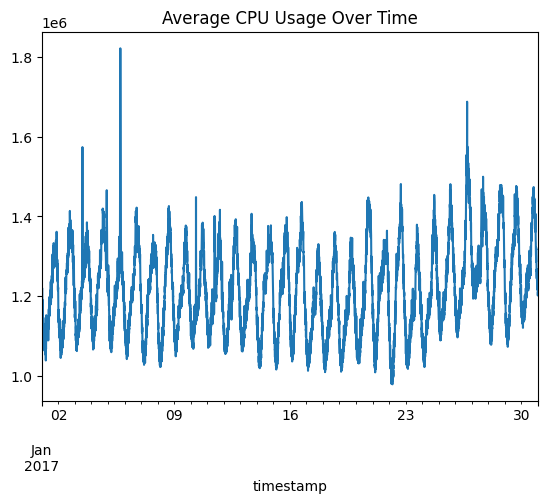

In [16]:
df['avg cpu'].plot(title='Average CPU Usage Over Time')

# Split Dataset

In [17]:
# Define a point to split the data (e.g., 80% train, 20% test)
split_point = int(len(df) * 0.8)
train, test = df.iloc[:split_point], df.iloc[split_point:]

# Display sizes of the datasets
print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

Training data size: 6912
Testing data size: 1728


# Check if Data is stationary or not

In [18]:

result = adfuller(train['avg cpu'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Data is stationary since p value not greater than 0.05

ADF Statistic: -9.260116951438105
p-value: 1.4145410931808e-15


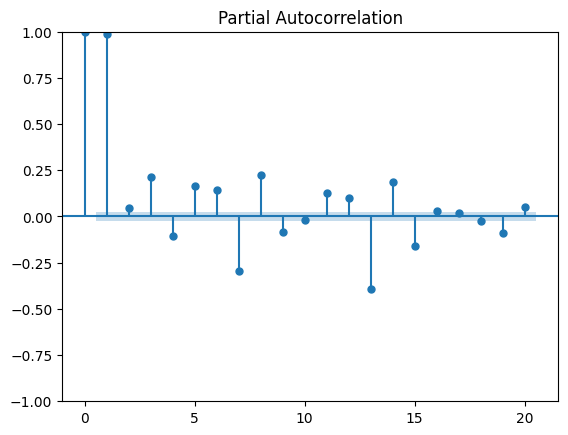

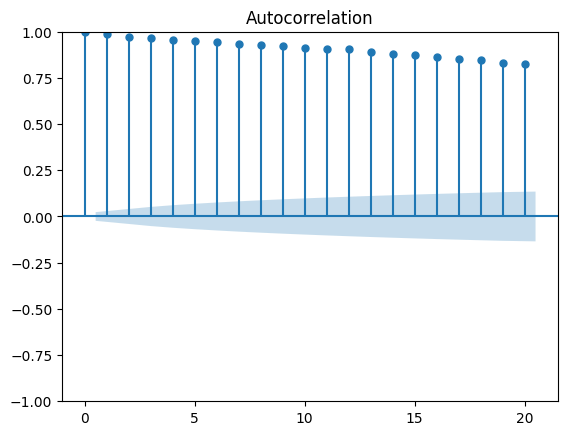

In [19]:
plot_pacf(train['avg cpu'], lags=20)  # Helps to determine 'p'
plt.show()

plot_acf(train['avg cpu'], lags=20)   # Helps to determine 'q'
plt.show()

# Determine best p,d,q value for fitting Arima model 

In [21]:
def evaluate_arima_model(train_data, order):
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit.aic

def arima_grid_search(train, p_values, d_values, q_values):
    train = train.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    aic = evaluate_arima_model(train, order)
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print(f'ARIMA{order} AIC={aic:.3f}')
                except:
                    continue
    ##print(f'Best ARIMA{best_cfg} AIC={best_score:.3f}')
    return best_cfg

In [22]:
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

best_order = arima_grid_search(train['avg cpu'], p_values, d_values, q_values)


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(0, 0, 0) AIC=233499.343
ARIMA(0, 0, 1) AIC=174495.696


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 2) AIC=173055.125


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 3) AIC=172776.319
ARIMA(0, 1, 0) AIC=154995.507


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(0, 1, 1) AIC=154976.472


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2) AIC=154756.584


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 3) AIC=154749.918
ARIMA(0, 2, 0) AIC=160109.615


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(0, 2, 1) AIC=156454.452


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 2) AIC=156006.374


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 3) AIC=155784.975
ARIMA(1, 0, 0) AIC=154972.821


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(1, 0, 1) AIC=154951.553


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) AIC=154603.247


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 3) AIC=154601.077
ARIMA(1, 1, 0) AIC=154981.907


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(1, 1, 1) AIC=154883.189


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) AIC=154748.220


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 3) AIC=154146.515


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 0) AIC=159112.305


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 1) AIC=156119.235


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 2) AIC=155864.177


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\Pych

ARIMA(1, 2, 3) AIC=155369.425
ARIMA(2, 0, 0) AIC=154961.249


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) AIC=154933.799


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) AIC=154602.854


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3) AIC=153501.177


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0) AIC=154778.222


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) AIC=154733.185


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\Pych

ARIMA(2, 1, 2) AIC=153394.159


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 3) AIC=153316.205
ARIMA(2, 2, 0) AIC=157520.865


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 1) AIC=155863.490


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 2) AIC=155777.508


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 3) AIC=155020.730


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 0) AIC=154638.168


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 1) AIC=154549.206


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 2) AIC=153090.249


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 3) AIC=152977.827


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 0) AIC=154746.340


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 1) AIC=154727.517


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\Pych

ARIMA(3, 1, 2) AIC=153394.321


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 3) AIC=153340.892
ARIMA(3, 2, 0) AIC=157319.759


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 2, 1) AIC=155839.976


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 2, 2) AIC=155252.019


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 2, 3) AIC=154288.319


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
best_order # Best p,d,q value

(3, 0, 3)

# Fit model

In [24]:
best_model = ARIMA(train['avg cpu'], order=best_order)
best_model_fit = best_model.fit()

# Forecast on test data
forecasts = best_model_fit.forecast(steps=len(test))

# In-sample predictions
in_sample_preds = best_model_fit.predict(start=train.index[0], end=train.index[-1])

c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


# Predict and Evaluate

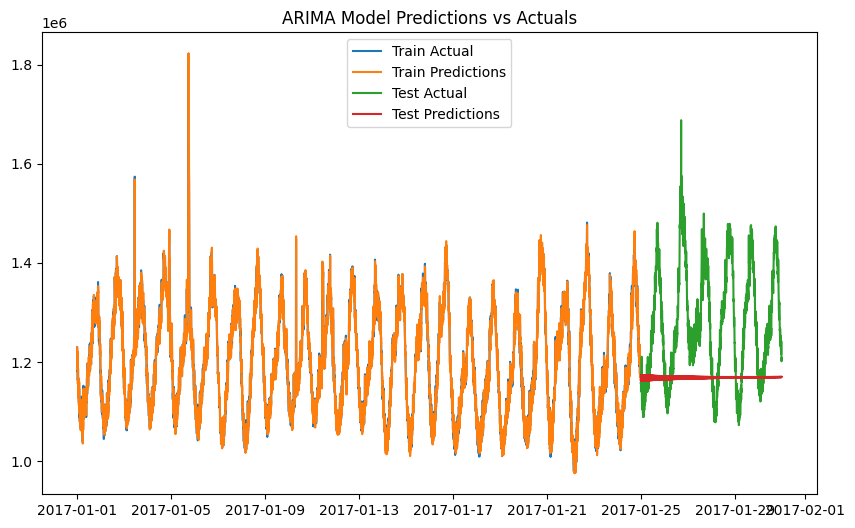

Train Mean Squared Error: 234347296.41
Train Root Mean Squared Error: 15308.41
Test Mean Squared Error: 23915411501.90
Test Root Mean Squared Error: 154646.08


In [25]:
# Calculate metrics
train_mse = mean_squared_error(train['avg cpu'], in_sample_preds)
test_mse = mean_squared_error(test['avg cpu'], forecasts)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['avg cpu'], label='Train Actual')
plt.plot(train.index, in_sample_preds, label='Train Predictions')
plt.plot(test.index, test['avg cpu'], label='Test Actual')
plt.plot(test.index, forecasts, label='Test Predictions')
plt.title('ARIMA Model Predictions vs Actuals')
plt.legend()
plt.show()

print(f'Train Mean Squared Error: {train_mse:.2f}')
print(f'Train Root Mean Squared Error: {train_rmse:.2f}')
print(f'Test Mean Squared Error: {test_mse:.2f}')
print(f'Test Root Mean Squared Error: {test_rmse:.2f}')


In [ ]:
# ARIMA model doesn't give better results.